# ToxOps IOPs (Australia)

In [1]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import h5netcdf
import pyinterp.backends.xarray  # Module that handles the filling of undefined values. (interpolating library)
import pyinterp.fill
import seaborn as sns
from matplotlib.patches import Rectangle


import re
from datetime import datetime
from collections import defaultdict

In [2]:
auth = earthaccess.login(persist=True)

In [3]:
tspan = ("2025-01-01", "2025-08-04")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_IOP",
    granule_name="*.DAY.*bb.4km.*",
    temporal=tspan
)

#results2 = earthaccess.search_data(
 #   short_name="PACE_OCI_L3M_IOP_NRT",
  #  granule_name="*.DAY.*bb.4km.*",
   # temporal=tspan
#)

#results = results1+results2
#len(results)

bb_paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/121 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/121 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/121 [00:00<?, ?it/s]

In [4]:
print(bb_paths[0:7])

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250101.L3m.DAY.IOP.V3_0.bb.4km.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250103.L3m.DAY.IOP.V3_0.bb.4km.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250104.L3m.DAY.IOP.V3_0.bb.4km.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250105.L3m.DAY.IOP.V3_0.bb.4km.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250106.L3m.DAY.IOP.V3_0.bb.4km.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250107.L3m.DAY.IOP.V3_0.bb.4km.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250108.L3m.DAY.IOP.V3_0.bb.4km.nc>]


In [5]:
provina = xr.open_mfdataset(bb_paths[0:7], combine="nested",
        concat_dim="date", coords="minimal")


In [6]:
provina

<xarray.Dataset> Size: 20GB
Dimensions:     (date: 7, lat: 4320, lon: 8640, wavelength: 19, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    bb          (date, lat, lon, wavelength) float32 20GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (date, rgb, eightbitcolor) uint8 5kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20250101.L3m.DAY.IOP.V3_0.bb....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/IOP/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2086379
    data_minimum:                      -0.02383
    data_maximum:                      0.3000001

In [7]:
provina_sub = provina.sel({"lat": slice(-32.7, -36), "lon": slice(135.5, 138.6)})

In [8]:
provina_sub

<xarray.Dataset> Size: 3MB
Dimensions:     (date: 7, lat: 79, lon: 74, wavelength: 19, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 316B -32.73 -32.77 -32.81 ... -35.9 -35.94 -35.98
  * lon         (lon) float32 296B 135.5 135.6 135.6 135.6 ... 138.5 138.5 138.6
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    bb          (date, lat, lon, wavelength) float32 3MB dask.array<chunksize=(1, 15, 74, 8), meta=np.ndarray>
    palette     (date, rgb, eightbitcolor) uint8 5kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20250101.L3m.DAY.IOP.V3_0.bb....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/IOP/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2086379
    data_minimum:                      -0.02383
    data_maximum:                      0.3000001

In [20]:
pr = provina_sub.mean(dim=("date","wavelength"), skipna=True).compute()
pr

<xarray.Dataset> Size: 30kB
Dimensions:  (lat: 79, lon: 74, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 316B -32.73 -32.77 -32.81 ... -35.9 -35.94 -35.98
  * lon      (lon) float32 296B 135.5 135.6 135.6 135.6 ... 138.5 138.5 138.6
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    bb       (lat, lon) float32 23kB nan nan nan ... 0.003572 0.003531 0.00339
    palette  (rgb, eightbitcolor) float64 6kB 147.0 0.0 108.0 ... 0.0 0.0 0.0

In [21]:
pr["bb"]

<xarray.DataArray 'bb' (lat: 79, lon: 74)> Size: 23kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00362474, 0.00353158, 0.00353158, ..., 0.00404737, 0.00400685,
        0.00378527],
       [0.00358566, 0.00353356, 0.00352579, ..., 0.00382501, 0.00362632,
        0.00362632],
       [0.00342027, 0.00342027, 0.00342053, ..., 0.00357237, 0.00353053,
        0.00339027]], shape=(79, 74), dtype=float32)
Coordinates:
  * lat      (lat) float32 316B -32.73 -32.77 -32.81 ... -35.9 -35.94 -35.98
  * lon      (lon) float32 296B 135.5 135.6 135.6 135.6 ... 138.5 138.5 138.6

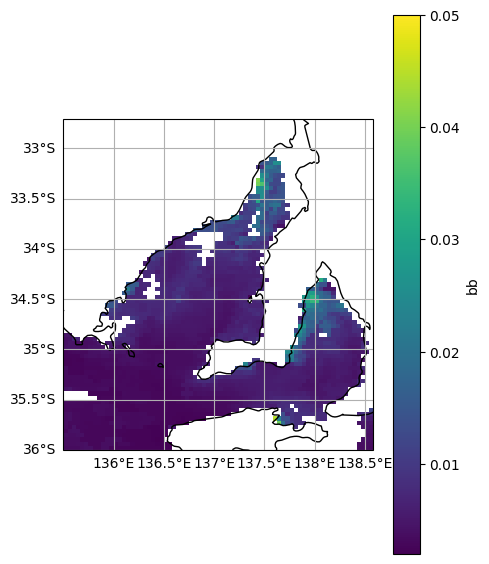

In [25]:
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pr["bb"].plot(x='lon', y='lat', cmap="viridis", vmax=.05)

In [9]:
provina_sub_mean = provina_sub.mean(dim=("lon", "lat")).compute()

In [10]:
provina_sub_mean

<xarray.Dataset> Size: 6kB
Dimensions:     (date: 7, wavelength: 19, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    bb          (date, wavelength) float32 532B 0.01376 0.01283 ... 0.002159
    palette     (date, rgb, eightbitcolor) uint8 5kB 147 0 108 144 0 ... 0 0 0 0

In [11]:
provina_sub_mean["bb"]["wavelength"]

<xarray.DataArray 'wavelength' (wavelength: 19)> Size: 152B
array([351., 361., 385., 413., 425., 442., 460., 475., 490., 510., 532., 555.,
       583., 618., 640., 655., 665., 678., 711.])
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
Attributes:
    long_name:  wavelengths
    units:      nm
    valid_min:  0
    valid_max:  20000

In [12]:
provina_sub_mean["bb"][0]

<xarray.DataArray 'bb' (wavelength: 19)> Size: 76B
array([0.01375927, 0.01283337, 0.01097287, 0.00948023, 0.00893817,
       0.00825394, 0.00769074, 0.00726436, 0.00688692, 0.00644655,
       0.00601764, 0.00564919, 0.00526894, 0.00486803, 0.00464863,
       0.00451427, 0.00442947, 0.00431862, 0.00408332], dtype=float32)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

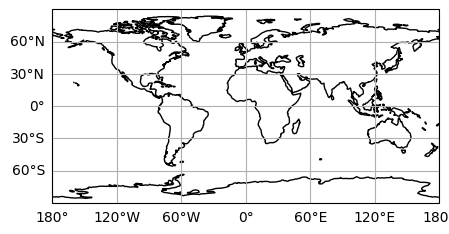

In [14]:
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = provina_sub_mean["bb"][0].values.plot(x='lon', y='lat', cmap="viridis", vmax=5)

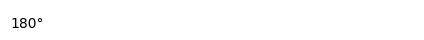

In [15]:
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plt.plot(provina_sub_mean["bb"]["wavelength"], provina_sub_mean["bb"][0])

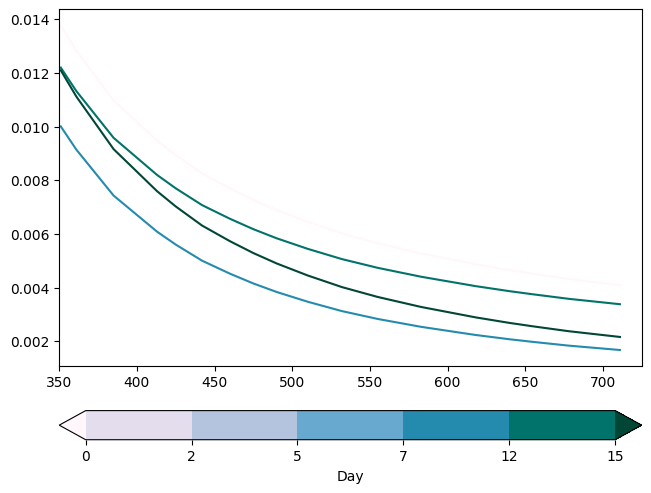

In [13]:
colors = pl.cm.PuBuGn(np.linspace(0,1,np.size(bb_paths[0:7])))

cmap = mpl.cm.PuBuGn
bounds = [0, 2, 5, 7, 12, 15]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig, ax = plt.subplots(layout='constrained')
for i in range(len(bb_paths[0:7])):
    plt.plot(provina_sub_mean["wavelength"].values,provina_sub_mean["bb"].values[i], color=colors[i], label='%s day' % i)
    plt.xlim([350,725])
    #plt.ylim([-0.001,0.011])


fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="Day")

In [4]:
## ChatGPT - for monthly

# Step 1: Group paths by year-month (e.g. '2025-03') for bb
paths_by_month_bb = defaultdict(list)

for path in bb_paths:
    match = re.search(r'(\d{6})\d{2}', str(path))  # Match YYYYMMDD
    if match:
        yyyymm = match.group(1)  # '202503'
        paths_by_month_bb[yyyymm].append(path)

# Step 2: Load each group into a dataset with real dates for bb
datasets_by_month_bb = {}

for yyyymm, file_group in paths_by_month_bb.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together to ensure correct order
    file_date_pairs = sorted(zip(dates, file_group), key=lambda x: x[0])
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset for this month
    ds_bb = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))

    
    ds_bb_sub = ds_bb.sel({"lat": slice(-32.7, -36), "lon": slice(135.5, 138.6)})
    ds_bb_sub_mean = ds_bb_sub.mean(dim=("lon", "lat")).compute()
    datasets_by_month_bb[yyyymm] = ds_bb_sub_mean

In [ ]:
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = sliced_ds.plot(x='lon', y='lat', cmap="viridis", vmax=5)

In [ ]:
datasets_by_month_bb['202503']

In [12]:
datasets_by_month_bb['202503']['bb'].mean('date')

<xarray.DataArray 'bb' (lat: 4320, lon: 8640, wavelength: 19)> Size: 3GB
dask.array<mean_agg-aggregate, shape=(4320, 8640, 19), dtype=float32, chunksize=(16, 1024, 8), chunktype=numpy.ndarray>
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [ ]:
sliced_ds_bb = 

In [8]:
sliced_ds_bb = datasets_by_month_bb['202503']['bb'].mean(dim=("lon", "lat")).compute().sel(lat=slice(-32.7, -36), lon=slice(135.5, 138.6), ) #slice must be big small, small big 
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = sliced_ds_bb["wavelength"].plot(x='lon', y='lat', cmap="viridis", vmax=5)

PermissionError: The provided token has expired.

In [8]:
## ChatGPT - for weekly

# Step 1: Group paths by ISO week (e.g. '2025-W09') for bb
paths_by_week_bb = defaultdict(list)

for path in bb_paths:
    match = re.search(r'(\d{8})', str(path))  # Match full date (YYYYMMDD)
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        week_id = f"{date_obj.isocalendar().year}-W{date_obj.isocalendar().week:02d}"
        paths_by_week_bb[week_id].append(path)

# Step 2: Load each group into a dataset with real dates for bb
datasets_by_week_bb = {}

for week_id, file_group in paths_by_week_bb.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together
    file_date_pairs = sorted(zip(dates, file_group))
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset and assign the correct dates
    ds_bb = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))
   
    ds_bb = ds_bb.sel({"lon": slice(135.5, 138.6), "lat": slice(-32.7, -36)})
    datasets_by_week_bb[week_id] = ds_bb

TypeError: '<' not supported between instances of 'EarthAccessFile' and 'EarthAccessFile'

In [9]:
##ChatGPT - for daily

# Extract date from each path and sort for bb
file_date_pairs = []
for path in bb_paths:
    match = re.search(r'(\d{8})', str(path))  # Extract YYYYMMDD
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        file_date_pairs.append((date_obj, path))

# Sort files chronologically
file_date_pairs = sorted(file_date_pairs)
sorted_dates, sorted_paths = zip(*file_date_pairs)

# Load all files and assign their corresponding dates to the 'date' dimension
dataset_daily_bb = xr.open_mfdataset(
    sorted_paths,
    combine="nested",
    concat_dim="date"
).assign_coords(date=("date", pd.to_datetime(sorted_dates)))

### Absorption Coefficient

In [ ]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_IOP_NRT",
    granule_name="*.DAY.*a.4km.*",
    temporal=tspan
)

a_paths = earthaccess.open(results)
print(len(a_paths))

In [ ]:
## ChatGPT - for monthly

# Step 1: Group paths by year-month (e.g. '2025-03') for a
paths_by_month_a = defaultdict(list)

for path in a_paths:
    match = re.search(r'(\d{6})\d{2}', str(path))  # Match YYYYMMDD
    if match:
        yyyymm = match.group(1)  # '202503'
        paths_by_month_a[yyyymm].append(path)

# Step 2: Load each group into a dataset with real dates for a
datasets_by_month_a = {}

for yyyymm, file_group in paths_by_month_a.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together to ensure correct order
    file_date_pairs = sorted(zip(dates, file_group))
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset for this month
    ds_a = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))

    datasets_by_month_a[yyyymm] = ds_a


In [ ]:
## ChatGPT - for weekly

# Step 1: Group paths by ISO week (e.g. '2025-W09') for a 
paths_by_week_a = defaultdict(list)

for path in a_paths:
    match = re.search(r'(\d{8})', str(path))  # Match full date (YYYYMMDD)
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        week_id = f"{date_obj.isocalendar().year}-W{date_obj.isocalendar().week:02d}"
        paths_by_week_a[week_id].append(path)

# Step 2: Load each group into a dataset with real dates for a
datasets_by_week_a = {}

for week_id, file_group in paths_by_week_a.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together
    file_date_pairs = sorted(zip(dates, file_group))
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset and assign the correct dates
    ds_a = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))

    datasets_by_week_a[week_id] = ds_a


In [ ]:
##ChatGPT - for daily

# Extract date from each path and sort for a
file_date_pairs = []
for path in a_paths:
    match = re.search(r'(\d{8})', str(path))  # Extract YYYYMMDD
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        file_date_pairs.append((date_obj, path))

# Sort files chronologically
file_date_pairs = sorted(file_date_pairs)
sorted_dates, sorted_paths = zip(*file_date_pairs)

# Load all files and assign their corresponding dates to the 'date' dimension
dataset_daily_a = xr.open_mfdataset(
    sorted_paths,
    combine="nested",
    concat_dim="date"
).assign_coords(date=("date", pd.to_datetime(sorted_dates)))

In [ ]:
bb = xr.open_mfdataset(bb_paths, combine="nested", concat_dim="date", coords='minimal')
a = xr.open_mfdataset(a_paths, combine="nested", concat_dim="date", coords='minimal')

Bounding box (lat=slice(-32.7, -36), lon=slice(135.5, 138.6)

In [ ]:
a_sub = a.sel({"lon": slice(135.5, 138.6), "lat": slice(-32.7, -36)})
a_sub_mean = a_sub.mean(dim=("lon", "lat")).compute()

bb_sub = bb.sel({"lon": slice(135.5, 138.6), "lat": slice(-32.7, -36)})
bb_sub_mean = bb_sub.mean(dim=("lon", "lat")).compute()